- This notebook is to show WD metrics for active learning

In [2]:
import numpy as np
# import matplotlib.pylab as pl
import ot
import ot.plot

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# PCA decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance

In [3]:
import pickle
from tqdm import tqdm

In [4]:
myfile =r'../Data/CombinedPSP.csv'
df_load = pd.read_csv(myfile)

df_load['JSC']=df_load['JSC'].abs()
df_reduce=df_load.iloc[:,3:]
df_refine=df_reduce.iloc[:,np.r_[0:3,4:23]]
df_refine

,JSC,ABS_f_D,DISS_wf10_D,STAT_e,STAT_n_D,STAT_n_A,STAT_CC_D,STAT_CC_A,STAT_CC_D_An,STAT_CC_A_Ca,...,CT_f_e_conn,CT_f_conn_D_An,CT_f_conn_A_Ca,CT_e_conn,CT_e_D_An,CT_e_A_Ca,CT_f_D_tort1,CT_f_A_tort1,CT_n_D_adj_An,CT_n_A_adj_Ca
0,60.626,0.494161,0.455724,2402,20014,20487,10,8,4,4,...,0.529559,0.639502,0.907551,1272,1533,2156,0.353934,0.268703,145,176
1,60.143,0.499395,0.429118,2227,20226,20275,7,9,2,3,...,0.333633,0.691437,0.668508,743,1533,1454,0.390204,0.332153,147,174
2,57.374,0.497914,0.400567,2053,20166,20335,9,7,4,4,...,0.531417,0.679163,0.875387,1091,1370,1785,0.457068,0.326105,155,185
3,51.381,0.495617,0.379442,1933,20073,20428,9,7,4,4,...,0.538024,0.684452,0.880948,1040,1301,1684,0.507242,0.351967,157,180
4,48.672,0.491198,0.340753,1723,19894,20607,10,6,5,4,...,0.603018,0.700010,0.930169,1039,1186,1586,0.587606,0.351263,174,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,40.300,0.376040,0.367105,1730,15230,25271,17,1,4,1,...,0.154913,0.160210,1.000000,268,262,1776,1.000000,0.418978,133,229
1704,38.300,0.375645,0.355383,1632,15214,25287,15,1,4,1,...,0.166667,0.165966,1.000000,272,266,1670,1.000000,0.425476,133,228
1705,33.400,0.375003,0.337699,1532,15188,25313,14,1,4,1,...,0.172977,0.163682,1.000000,265,258,1566,1.000000,0.415873,130,225
1706,21.500,0.373620,0.317051,1403,15132,25369,11,1,3,1,...,0.132573,0.114922,1.000000,186,181,1430,1.000000,0.442233,93,247


In [5]:
x = df_refine.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_refine_standardize = pd.DataFrame(x_scaled)
df_refine_standardize.columns=df_refine.columns
df_refine_standardize

,JSC,ABS_f_D,DISS_wf10_D,STAT_e,STAT_n_D,STAT_n_A,STAT_CC_D,STAT_CC_A,STAT_CC_D_An,STAT_CC_A_Ca,...,CT_f_e_conn,CT_f_conn_D_An,CT_f_conn_A_Ca,CT_e_conn,CT_e_D_An,CT_e_A_Ca,CT_f_D_tort1,CT_f_A_tort1,CT_n_D_adj_An,CT_n_A_adj_Ca
0,-0.485075,1.320169,0.087262,-0.006062,1.320161,-1.320161,-0.614829,1.114886,-0.824615,0.924866,...,1.109499,0.752834,-0.039552,1.454934,0.890408,-0.067287,-1.242632,-0.543406,-1.214708,-0.819939
1,-0.499940,1.444165,-0.087533,-0.157241,1.444167,-1.444167,-0.779685,1.377647,-1.481384,0.352936,...,-0.020990,0.949669,-1.491452,0.064221,0.890408,-0.643667,-1.111462,-0.149221,-1.168102,-0.872776
2,-0.585163,1.409079,-0.275106,-0.307555,1.409071,-1.409071,-0.669781,0.852126,-0.824615,0.924866,...,1.120220,0.903150,-0.234910,0.979095,0.650772,-0.371898,-0.869648,-0.186794,-0.981680,-0.582170
3,-0.769611,1.354663,-0.413892,-0.411220,1.354672,-1.354672,-0.669781,0.852126,-0.824615,0.924866,...,1.158342,0.923195,-0.201134,0.845019,0.549332,-0.454824,-0.688194,-0.026125,-0.935074,-0.714264
4,-0.852987,1.249975,-0.668069,-0.592634,1.249969,-1.249969,-0.614829,0.589365,-0.496230,0.924866,...,1.533357,0.982160,0.097825,0.842390,0.380264,-0.535288,-0.397559,-0.030499,-0.538926,-1.136963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,-1.110655,-1.478167,-0.494943,-0.586587,-1.478165,1.478165,-0.230167,-0.724438,-0.824615,-0.790924,...,-1.052201,-1.063688,0.521964,-1.184528,-0.978161,-0.379287,1.093861,0.390183,-1.494342,0.580252
1704,-1.172210,-1.487525,-0.571953,-0.671247,-1.487524,1.487524,-0.340070,-0.724438,-0.824615,-0.790924,...,-0.984381,-1.041872,0.521964,-1.174013,-0.972280,-0.466319,1.093861,0.430552,-1.494342,0.553834
1705,-1.323019,-1.502734,-0.688133,-0.757635,-1.502733,1.502733,-0.395022,-0.724438,-0.824615,-0.790924,...,-0.947972,-1.050529,0.521964,-1.192415,-0.984042,-0.551709,1.093861,0.370893,-1.564251,0.474578
1706,-1.689269,-1.535498,-0.823785,-0.869075,-1.535489,1.535489,-0.559878,-0.724438,-1.153000,-0.790924,...,-1.181102,-1.235330,0.521964,-1.400102,-1.097244,-0.663372,1.093861,0.534655,-2.426456,1.055789


In [6]:
X = df_refine_standardize.loc[:,['STAT_e', 'DISS_f10_D', 'CT_n_D_adj_An', 'CT_n_A_adj_Ca', 'DISS_wf10_D']]    
y = df_refine_standardize.loc[:,['JSC']]  

In [7]:
dataPoolL0 = pd.concat([X,y], axis=1)

In [8]:
def load_pickle_data(file_path):
    # Load the .pkl file
    with open(file_path, 'rb') as file:
        load_data = pickle.load(file)
        
    return load_data

In [9]:
load_data1 = load_pickle_data('../Results_Data/Random_results_data_2023-12-29_10-21-38.pkl')
load_data2 = load_pickle_data('../Results_Data/Uncertainty_results_data_2023-12-29_13-47-17.pkl')
load_data3 = load_pickle_data('../Results_Data/GSx_results_data_2023-12-29_15-56-53.pkl')
load_data4 = load_pickle_data('../Results_Data/GSy_results_data_2023-12-29_21-00-15.pkl')
load_data5 = load_pickle_data('../Results_Data/iGS_results_data_2023-12-30_16-13-33.pkl')

In [10]:
dataPoolL1 = np.array(load_data1['SelectData1'])
dataPoolL2 = np.array(load_data2['SelectData1'])
dataPoolL3 = np.array(load_data3['SelectData1'])
dataPoolL4 = np.array(load_data4['SelectData1'])
dataPoolL5 = np.array(load_data5['SelectData1'])

In [11]:
def PCA_decomposition(df):
    X = df.iloc[:, 0:-1]

    pca=PCA()
    pca.fit(X)
    pca_data=pca.transform(X)

    per_var=np.round(pca.explained_variance_ratio_*100,decimals=1)
    print(f'Variance explained: {per_var}')
   
    return pca_data,pca

In [12]:
def optimal_transport(df1, df2):
    
    xx0 = df1
    xx1 = df2
   
    a0, a1 = np.ones((xx0.shape[0]),) / xx0.shape[0], np.ones((xx1.shape[0]),) / xx1.shape[0]

    M0=ot.dist(xx0,xx1)
    M0/=M0.max()
    d_emd0 = ot.emd2(a0, a1, M0)

    return d_emd0

In [13]:
pca_data,_ = PCA_decomposition(dataPoolL0)
p0 = pca_data
p0=pca_data[:,0:3]
p0.shape

Variance explained: [57.4 22.9 16.9  2.7  0.1]


(1708, 3)

In [39]:
def Check_metric(metrics='sqeuclidean'):
#     metrics1=metrics
    pca_data,pca_model = PCA_decomposition(dataPoolL0)
    p0 = pca_data
    p0=p0[:,0:3]
    
    def optimal_transport(df1, df2, metrics):

        xx0 = df1
        xx1 = df2
        a0, a1 = np.ones((xx0.shape[0]),) / xx0.shape[0], np.ones((xx1.shape[0]),) / xx1.shape[0]
        M0=ot.dist(xx0,xx1, metric=metrics)
        M0/=M0.max()
        d_emd0 = ot.emd2(a0, a1, M0)
        
        return d_emd0
    
    
    def distribution_distance(dataPoolL,p0,method,runs=20,pc=0):
    # Calculating distribution    
        p=[]
        P=[]
        for run in range(runs):
            p=[]
            df = pd.DataFrame(dataPoolL[run])
            for i,c in enumerate(np.arange(10,508,1)):# change later
                pca_data= pca_model.transform(df.iloc[0:c,0:-1])
                pca_data=pca_data[:,0:3]
                p.append(pca_data)
            P.append(p)



        # Calculating distance for distribution
        Distance=np.zeros((1,498))
        KL = np.zeros((1,498))
        Distance_average=np.zeros((20,498))
        KL_average = np.zeros((20,498))
        for i in range(len(P)):
            p = P[i]
            for j in range(len(p)):
                distance=optimal_transport(p[j],p0,metrics)
                Distance[0][j]=distance
            Distance_average[i]=np.array(Distance)
        W_distance = np.mean(Distance_average, axis=0)
        W_distance_std = np.std(Distance_average, axis=0)

        return W_distance, W_distance_std

    

    Distance_RS,Distance_RS_std = distribution_distance(dataPoolL1, p0, method='Random sampling')

    Distance_US,Distance_US_std = distribution_distance(dataPoolL2, p0, method='Uncertainty sampling')

    Distance_GSx,Distance_GSx_std = distribution_distance(dataPoolL3, p0, method='GSx')

    Distance_GSy,Distance_GSy_std = distribution_distance(dataPoolL4, p0, method='GSy')

    Distance_iGS,Distance_iGS_std = distribution_distance(dataPoolL5, p0, method='iGS')

    # euclidean
    plt.plot(np.arange(10, 508, 1), Distance_RS, label='Random sampling')
    plt.fill_between(np.arange(10, 508, 1), Distance_RS - Distance_RS_std, 
                     Distance_RS + Distance_RS_std, alpha=0.2)

    plt.plot(np.arange(10, 508, 1), Distance_US, label='Uncertainty sampling')
    plt.fill_between(np.arange(10, 508, 1), Distance_US - Distance_US_std, 
                     Distance_US + Distance_US_std, alpha=0.2)

    plt.plot(np.arange(10, 508, 1), Distance_GSx, label='GSx')
    plt.fill_between(np.arange(10, 508, 1), Distance_GSx - Distance_GSx_std, 
                     Distance_GSx + Distance_GSx_std, alpha=0.2)

    plt.plot(np.arange(10, 508, 1), Distance_iGS, label='iGS')
    plt.fill_between(np.arange(10, 508, 1), Distance_iGS - Distance_iGS_std, 
                     Distance_iGS + Distance_iGS_std, alpha=0.2)

    plt.plot(np.arange(10, 508, 1), Distance_GSy, label='GSy')
    plt.fill_between(np.arange(10, 508, 1), Distance_GSy - Distance_GSy_std, 
                     Distance_GSy + Distance_GSy_std, alpha=0.2)

    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Wasserstein Distance')
    # plt.title(f'{method}')
    # plt.ylim(0,0.055)
    plt.show()

Variance explained: [57.4 22.9 16.9  2.7  0.1]


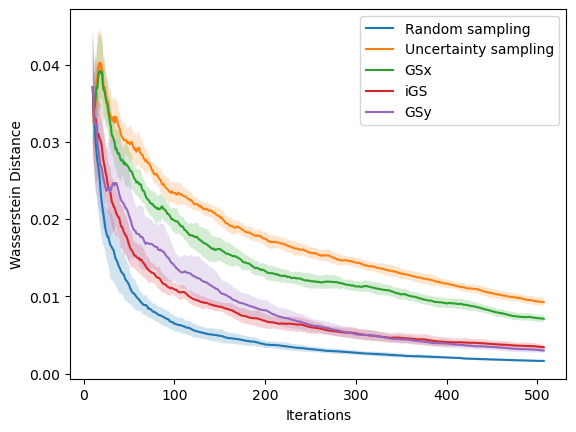

In [40]:
Check_metric(metrics='sqeuclidean')

In [14]:
def Check_metric(metrics='sqeuclidean'):
#     metrics1=metrics
    pca_data,pca_model = PCA_decomposition(dataPoolL0)
    p0 = pca_data
    p0=p0[:,0:3]
    
    def optimal_transport(df1, df2, metrics):

        xx0 = df1
        xx1 = df2
        a0, a1 = np.ones((xx0.shape[0]),) / xx0.shape[0], np.ones((xx1.shape[0]),) / xx1.shape[0]
        M0=ot.dist(xx0,xx1, metric=metrics)
        M0/=M0.max()
        d_emd0 = ot.emd2(a0, a1, M0)
        
        return d_emd0
    
    
    def distribution_distance(dataPoolL,p0,method,runs=20,pc=0):
    # Calculating distribution    
        p=[]
        P=[]
        for run in tqdm(range(runs)):
            p=[]
            df = pd.DataFrame(dataPoolL[run])
            for i,c in enumerate(np.arange(10,508,1)):# change later
                pca_data= pca_model.transform(df.iloc[0:c,0:-1])
                pca_data=pca_data[:,0:3]
                p.append(pca_data)
            P.append(p)



        # Calculating distance for distribution
        Distance=np.zeros((1,498))
        KL = np.zeros((1,498))
        Distance_average=np.zeros((20,498))
        KL_average = np.zeros((20,498))
        for i in range(len(P)):
            p = P[i]
            for j in range(len(p)):
                distance=optimal_transport(p[j],p0,metrics)
                Distance[0][j]=distance
            Distance_average[i]=np.array(Distance)
        W_distance = np.mean(Distance_average, axis=0)
        W_distance_std = np.std(Distance_average, axis=0)

        return W_distance, W_distance_std

    

    Distance_RS,Distance_RS_std = distribution_distance(dataPoolL1, p0, method='Random sampling')

    Distance_US,Distance_US_std = distribution_distance(dataPoolL2, p0, method='Uncertainty sampling')

    Distance_GSx,Distance_GSx_std = distribution_distance(dataPoolL3, p0, method='GSx')

    Distance_GSy,Distance_GSy_std = distribution_distance(dataPoolL4, p0, method='GSy')

    Distance_iGS,Distance_iGS_std = distribution_distance(dataPoolL5, p0, method='iGS')

    return Distance_RS,Distance_RS_std, Distance_US,Distance_US_std, Distance_GSx,Distance_GSx_std, Distance_GSy,Distance_GSy_std, \
    Distance_iGS,Distance_iGS_std

In [15]:
# save_path='Results_Plot/'
filename='Results_wasserstein'

In [16]:
d1, s1, d2, s2, d3, s3, d4, s4, d5, s5 = Check_metric(metrics='sqeuclidean')

Variance explained: [57.4 22.9 16.9  2.7  0.1]


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


In [19]:
# Save data
data_dict = {'d1': d1, 's1': s1, 'd2': d2, 's2': s2, 'd3': d3, 's3': s3, 'd4': d4, 's4': s4, 'd5': d5, 's5': s5}

# Specify the file path where you want to save the objects
file_path = 'Distance_Wasserstein.pkl'

# Open the file in binary write mode and dump the data_dict into it
with open(file_path, 'wb') as file:
    pickle.dump(data_dict, file)

In [52]:
def plot_curves(d1, d2, d3, d4, d5, s1, s2, s3, s4, s5, filename):
    fig, ax = plt.subplots()

    # offset = 10
    error_freq = 30
    
    # List of your datasets and their corresponding standard deviation arrays
    datasets = [d1, d2, d3, d4, d5]
    std_devs = [s1, s2, s3, s4, s5]
        
    labels = ['Random sampling', 'Uncertainty sampling', 'GSx', 'GSy', 'iGS']
    # colors = ['blue', 'orange', 'green', 'purple', 'red']
    tableau_colors = plt.get_cmap('tab10').colors[:5]
    # Shift 4th and 5th colors to the first two positions
    shifted_colors = tableau_colors[:3] + tableau_colors[4:5] + tableau_colors[3:4] 
    offsets = [10, 20, 30, 40, 50]
    
    for i, (dataset, std_dev, label, color, offset) in enumerate(zip(datasets, std_devs, labels, shifted_colors, offsets)):
        y = dataset
        e = std_dev
        x = np.arange(len(y))
        p = ax.plot(x+10, y, label=label, color=color)
    
        xe, ye, ee = (x+10)[offset::error_freq], y[offset::error_freq], e[offset::error_freq]
        xe, ye, ee = xe.flatten(), ye.flatten(), ee.flatten()
        ax.errorbar(xe, ye, yerr=ee, alpha=0.3, ls='none', ecolor=p[0].get_color(), elinewidth=2, capsize=3, capthick=2)
        offset += error_freq
    
    # # Your other plotting settings...
    # # optimal line
    # xx = [0, 100, 200, 300, 400, 500]
    # yy = [opt] * len(xx)
    # ee = [opt_error[0]] * len(xx)
    
    # p = ax.plot(xx, yy, 'k--', label='Optimal')
    
    # ax.errorbar(xx, yy, yerr=ee, alpha=0.3, ls='none', ecolor=p[-1].get_color(), elinewidth=2, capsize=3, capthick=2)
    
    plt.xlabel('Number of samples')
    plt.ylabel('Wasserstein distance')
    plt.legend()
    plt.savefig(filename, dpi=200)
    plt.show()

In [20]:
def plot_curves_update(d1, d2, d3, d4, d5, s1, s2, s3, s4, s5, filename):
    plt.style.use('ggplot')
    plt.rcParams['axes.facecolor']='w'
    
    fig, ax = plt.subplots()

    # offset = 10
    error_freq = 30
    
    # List of your datasets and their corresponding standard deviation arrays
    datasets = [d3, d4, d5, d1, d2]
    std_devs = [s3, s4, s5, s1, s2]
        
    labels = ['GSx', 'GSy', 'iGS', 'Random sampling', 'Uncertainty sampling']
    
    line_styles = {
    'Uncertainty sampling': 'solid',
    'Random sampling': 'dotted',
    'GSx': 'dashed',
    'GSy': 'dashdot',
    'iGS': (5, (10, 3))}
    offsets = [10, 20, 30, 40, 50]
    
    for i, (dataset, std_dev, label, offset) in enumerate(zip(datasets, std_devs, labels, offsets)):
        y = dataset
        e = std_dev
        x = np.arange(len(y))
        line_style = line_styles[label]
        p = ax.plot(x+10, y, label=label, linestyle=line_style)
    
        xe, ye, ee = (x+10)[offset::error_freq], y[offset::error_freq], e[offset::error_freq]
        xe, ye, ee = xe.flatten(), ye.flatten(), ee.flatten()
        ax.errorbar(xe, ye, yerr=ee, alpha=0.3, ls='none', ecolor=p[0].get_color(), elinewidth=2, capsize=3, capthick=2)
        offset += error_freq
    
    plt.xlabel('Number of samples')
    plt.ylabel('Wasserstein distance')
    plt.legend()
    plt.savefig(filename, dpi=300)
    plt.show()

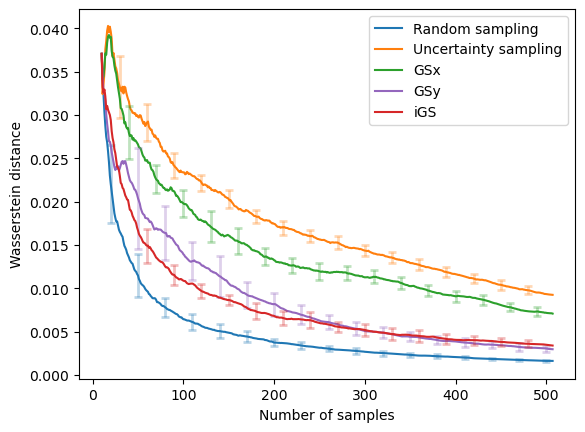

In [53]:
plot_curves(d1, d2, d3, d4, d5, s1, s2, s3, s4, s5, filename)

In [ ]:
pwd

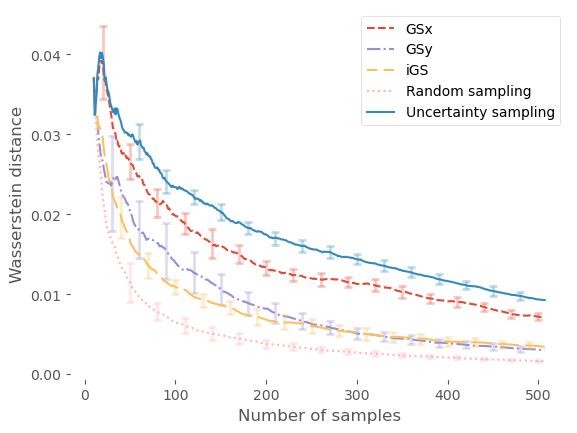

In [21]:
filename='Results_wasserstein_update'
plot_curves_update(d1, d2, d3, d4, d5, s1, s2, s3, s4, s5, filename)

In [47]:
d1

array([0.0370564 , 0.03426898, 0.03221934, 0.0303443 , 0.02873537,
       0.02748724, 0.02685153, 0.02579673, 0.02455938, 0.02302335,
       0.02203039, 0.0211848 , 0.02030837, 0.01953743, 0.01866259,
       0.01814676, 0.0177313 , 0.01772361, 0.01726538, 0.0167703 ,
       0.01651281, 0.0163354 , 0.01610944, 0.01594541, 0.01538586,
       0.0149145 , 0.01470331, 0.01445533, 0.0140591 , 0.01380681,
       0.01358102, 0.01325157, 0.01307849, 0.01292403, 0.01284384,
       0.01250194, 0.01217024, 0.01202184, 0.0119034 , 0.01165824,
       0.01148869, 0.01107605, 0.01087814, 0.01061196, 0.01046837,
       0.01036973, 0.01028635, 0.01013832, 0.00993414, 0.0097969 ,
       0.00969692, 0.00959641, 0.00935141, 0.00929608, 0.00912184,
       0.00901371, 0.00887307, 0.00885099, 0.00887218, 0.00884172,
       0.0086739 , 0.00841019, 0.00841869, 0.00835406, 0.00828772,
       0.00818169, 0.00804124, 0.00796741, 0.00797451, 0.00789781,
       0.00780969, 0.00773735, 0.00762905, 0.0075716 , 0.00752

In [48]:
d2

array([0.0370564 , 0.03241185, 0.03354934, 0.03488852, 0.03757569,
       0.03851239, 0.03969795, 0.04027232, 0.03952293, 0.04018041,
       0.03960767, 0.03880638, 0.03678886, 0.0371545 , 0.03638599,
       0.03561908, 0.03536722, 0.03485851, 0.03397581, 0.03357023,
       0.03320946, 0.03285734, 0.03271967, 0.03325602, 0.03248827,
       0.03325624, 0.03317881, 0.03260617, 0.03219125, 0.03183359,
       0.03156454, 0.0309366 , 0.03063495, 0.03052399, 0.03024954,
       0.03026366, 0.03015739, 0.03019237, 0.02988986, 0.02998523,
       0.02978056, 0.02970247, 0.02998216, 0.02993887, 0.0295509 ,
       0.0292549 , 0.02899297, 0.02918957, 0.02872087, 0.02894638,
       0.02913032, 0.02924286, 0.02865106, 0.02847002, 0.02829996,
       0.02830295, 0.02785233, 0.02775866, 0.02747913, 0.02763951,
       0.02735927, 0.02725181, 0.02725256, 0.02693012, 0.02677817,
       0.02633416, 0.02631966, 0.0259165 , 0.02578234, 0.0258139 ,
       0.02587412, 0.02557938, 0.02556877, 0.02521544, 0.02514

In [49]:
d3

array([0.0370564 , 0.03408137, 0.0344751 , 0.03548601, 0.03710874,
       0.03695472, 0.03833771, 0.03905146, 0.03922327, 0.0389156 ,
       0.0390152 , 0.03738391, 0.03671625, 0.03655003, 0.03570419,
       0.03512344, 0.03477988, 0.03395883, 0.03319986, 0.03251354,
       0.03187955, 0.03078431, 0.0307027 , 0.03036529, 0.0299406 ,
       0.02903086, 0.02916455, 0.02864175, 0.02843311, 0.02849563,
       0.02793531, 0.02757325, 0.02768056, 0.02762305, 0.02716093,
       0.02733514, 0.02703923, 0.02708371, 0.02694962, 0.02678641,
       0.02660401, 0.02627933, 0.02621877, 0.0261293 , 0.02578151,
       0.02543112, 0.02520688, 0.02509687, 0.02473402, 0.02475536,
       0.02479802, 0.02451106, 0.02448473, 0.0244984 , 0.02401096,
       0.02370309, 0.02363267, 0.02344637, 0.02305579, 0.0227957 ,
       0.02259345, 0.02247216, 0.0224172 , 0.02212957, 0.02205238,
       0.02192009, 0.02195577, 0.02175267, 0.02159281, 0.02158318,
       0.02140445, 0.02132484, 0.02142331, 0.02125959, 0.02131

In [50]:
d4

array([0.0370564 , 0.03434952, 0.03258421, 0.03253925, 0.03164477,
       0.03005815, 0.02897007, 0.02808101, 0.02697647, 0.02692958,
       0.02646551, 0.02569996, 0.02514871, 0.02453366, 0.02400724,
       0.02365271, 0.02398498, 0.02381681, 0.02409501, 0.02356632,
       0.02386601, 0.02424405, 0.02459577, 0.02468305, 0.02436395,
       0.02465909, 0.02466981, 0.02426767, 0.02381199, 0.02329353,
       0.02289218, 0.02248885, 0.02229198, 0.02218725, 0.0219911 ,
       0.02173035, 0.02141885, 0.02137137, 0.02112027, 0.02081453,
       0.02040119, 0.020092  , 0.01977797, 0.01926358, 0.01894521,
       0.01867233, 0.01853289, 0.01845443, 0.01812917, 0.0181067 ,
       0.01807226, 0.01803821, 0.01781989, 0.01764688, 0.01771307,
       0.01757207, 0.01733471, 0.01704604, 0.01679068, 0.0168523 ,
       0.01693217, 0.01688251, 0.01675909, 0.01679759, 0.01678803,
       0.01677549, 0.01667429, 0.01655442, 0.0164734 , 0.01643165,
       0.01638604, 0.01637306, 0.01604684, 0.01596891, 0.01603

In [51]:
d5

array([0.0370564 , 0.03323327, 0.03256067, 0.03294144, 0.03214041,
       0.03066755, 0.03105005, 0.03059592, 0.03030782, 0.03000456,
       0.02942078, 0.02814417, 0.02733908, 0.02685116, 0.02604161,
       0.02559778, 0.02483836, 0.02405114, 0.02390918, 0.02366198,
       0.02295756, 0.02216564, 0.02202148, 0.02159732, 0.02146112,
       0.02106583, 0.02071164, 0.02051132, 0.02024208, 0.02019567,
       0.01962533, 0.01906998, 0.0190024 , 0.01876001, 0.01837122,
       0.01814633, 0.01788193, 0.01776785, 0.01747555, 0.01701414,
       0.01668705, 0.01628893, 0.01607712, 0.01593491, 0.01572918,
       0.01547521, 0.01527176, 0.01524996, 0.01514249, 0.01499056,
       0.01492225, 0.01493516, 0.01468895, 0.01477725, 0.01461555,
       0.01440907, 0.01430222, 0.01414809, 0.0139509 , 0.01376768,
       0.01355771, 0.01346664, 0.01334986, 0.01323488, 0.01315875,
       0.01306578, 0.013046  , 0.01298434, 0.0128801 , 0.01270916,
       0.01252475, 0.01241506, 0.01242806, 0.01236006, 0.01224